## Optimization  

# Maximization-Minimization Algorithms

    Authors: Jesús Cid-Sueiro
    Version: 1.0, Apr. 2020.

### Write your data here:

#### Name and NIA: Leandro Hidalgo - 100391000
#### Name and NIA: Ignacio Serrano - 100418944

## Exercise: estimation of the parameters of a Gaussian mixture.

The goal of this exercise is to illustrate the Majorization-Minimization approach through a particular case: the Expectation-Maximization (EM) algorithm for Gaussian Mixture modelling.

To do so, we will make an implementation from scratch of a simple one-dimensional case, and will compare its behaviour with respect to a conventional gradient descent algorithm

In [0]:
import numpy as np
from scipy.stats import norm
from math import exp, pi, log

import matplotlib.pyplot as plt

%matplotlib inline

### Problem formulation

In the general setting (for a 1-dimensional case) of the Gaussian mixture modelling problem, i.i.d. samples in dataset ${\cal S} = \{x_0, \ldots, x_{K-1}\}$ are assumed to be drawn by a mixture of $M$ Gaussian distributions. 
$$
p(x) = \sum_{m=0}^{M-1} 
       \dfrac{p_m}{\sqrt{2\pi v_m}} \exp\left(-\dfrac{(x - w_m)^2}{2 v_m}\right)
$$
The goal is to estimate parameters $p_m$, $w_m$ and $v_m$, given ${\cal S}$ via maximum likelihood (ML).

In order to simplify the problem, in this notebook we will assume that priors and variances are known and given by
$$
p_m = \frac{1}{M}
$$
$$
v_m = 1
$$

Therefore, our goal is to find the ML estimate of parameters $w_m$, by solving the optimization problem
\begin{align}
{\bf w}^*
    &= \arg\max_{{\bf w}} \log\left(\prod_{k=0}^{K-1} p(x_k|{\bf w}) \right)  \\
    &= \arg\min_{{\bf w}} \text{NLL}({\bf w})    
\end{align}
where ${\bf w} = (w_0,\ldots, M-1)$, and NLL is the negative log-likelihood function
$$
\text{NLL}({\bf w}) = - \sum_{k=0}^{K-1} \log(p(x_k|{\bf w})) 
$$
$$
p(x|{\bf w}) = \sum_{m=0}^{M-1} 
       \dfrac{1}{M \sqrt{2\pi}} \exp\left(-\frac{1}{2}(x - w_m)^2 \right)
$$

### 1. Dataset generation

Generate a one-dimensional dataset ${\bf X}$ of 1000 samples from a GM with 10 components given by

In [0]:
w_true = np.array([[0., 3.1, 4.5, 17, 21.3, 30.8, 35., 42., 56., 77.]]).T

To do so, you can proceed in two steps:

1. Generate a random sequence of $N$ i.i.d. samples $z_k \in \{0,\ldots, M-1\}$ (with all values with the same probability).
2. For each $k$, generate sample $x_k$ according to a gaussian distibution with mean $w_{z_k}$.

Store the data in a column vector `X`.

In [0]:
M = len(w_true)

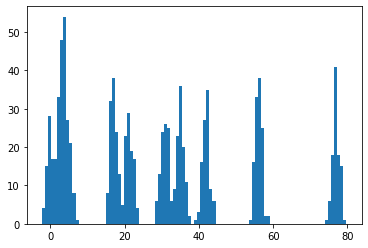

In [189]:
sample_size = 1000
var = 1
uniform_samples = np.floor(np.random.uniform(low=0.0, high=w_true.shape[0], size=sample_size))
X = np.zeros(uniform_samples.shape)
for k in range(sample_size):
  X[k] = np.random.normal(w_true[int(uniform_samples[k])], scale=var)

# You can plot the histogram here
h = plt.hist(X, bins=100)
plt.show()

### 2. Objective function

#### 2.1. NLL method.

Implement a method `gm` that, given a dataset ${\bf x}$ and parameter vector ${\bf w}$, computes the probability density function of each sample in ${\bf x}$, given ${\bf w}$.

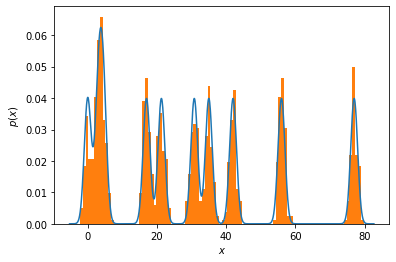

In [190]:
# <SOL>
from math import pi

def gm(dataset, w):
    p_xw = np.zeros((len(dataset),1))
    for i, sample in enumerate(dataset):  
        p = 0
        for j in range(len(w)):
            p += 1/(len(w)*np.sqrt(2*pi))*np.exp(-1/2*(sample - w[j])**2)
            
        p_xw[i] = p
        
    return p_xw
# </SOL>

# You can visualizace the GM, as a function of x, here 
xmin = np.min(X)
xmax = np.max(X)
sigma = 1
x_grid = np.array([np.linspace(xmin - 3 * sigma, xmax + 3 * sigma, num=1000)]).T
y = gm(x_grid, w_true)

plt.plot(x_grid, y)
plt.hist(X, bins=100, density=True)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.show()

#### 2.1. NLL method.

Implement a method `NLL` that, given a dataset ${\bf X}$ and parameter vector ${\bf w}$, computes the negative log-likelihood function $\text{NLL}({\bf w})$ for the dataset ${\bf X}$

$$
p(x|{\bf w}) = \sum_{m=0}^{M-1} 
       \dfrac{1}{M \sqrt{2\pi}} \exp\left(-\frac{1}{2}(x - w_m)^2 \right)
$$


In [0]:
# <SOL>
def NLL(dataset, w):
    nll = 0
    for sample in dataset:
        p = 0
        for i in range(len(w)):
            p += np.exp(-1/2*(sample - w[i])**2)/(len(w)*np.sqrt(2*np.pi))  
        
        nll -= np.log(p)
        
    return nll
# </SOL>

#### 2.2. Convexity

Show, visually, that the optimization problem is highly non-convex. To do so, fix $w_1, \ldots,  w_{M-1}$, to their true values and plot the NLL as a function of $w_0$.

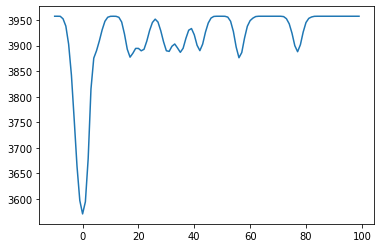

In [265]:
# <SOL>
w0 = np.arange(-10,100)
w_aux = np.zeros(w_true.shape) + w_true
NLL_convexity = []
for i in range(len(w0)):
    w_aux[0] = w0[i]
    NLL_convexity.append(NLL(X, w_aux))
    
plt.plot(w0,NLL_convexity)
# </SOL>

### 3. Gradient descent.

In this section we will estimate ${\bf w}$ by means of a standard gradient descent method.

#### 3.1. Gradient

Implement a method **`df`** to compute the gradient of the objective function with respect to ${\bf w}$. To do so, note that
\begin{align}
\nabla_{\bf w}(\text{NLL}({\bf w})) 
   &= - \sum_{k=0}^{K-1} \frac{\nabla_{\bf w} p(x_k|{\bf w})}{p(x_k|{\bf w})} 
    = \sum_{k=0}^{K-1} ({\bf w} - x_k{\mathbb{1}}) \odot {\bf q}(x_k)
\end{align}
where $\mathbb{1}$ is an all-ones vector, $\odot$ is the component-wise product and ${\bf q}(x_k)$ has components
$$
q_{m,k} = \dfrac{\dfrac{1}{M \sqrt{2\pi}} \exp\left(-\frac{1}{2}(x_k - w_m)^2 \right)}
            {p(x_k|{\bf w})}
$$
Defining matrix ${\bf Q}$ with components $q_{m,k}$, the can be written in a more compact form as
\begin{align}
\nabla_{\bf w}(\text{NLL}({\bf w})) 
   &= {\bf w}\odot({\bf Q}\mathbb{1}) - {\bf Q}{\bf x}
\end{align}

In [0]:
def getQ(w, data, p):
  
  q = np.zeros([len(w), len(data)])

  for m in range(len(w)):
    for k in range(len(data)):
      
      num = exp(-0.5*(data[k]-w[m])**2)/(len(w)*np.sqrt(2*pi))
      den = p[k]
      q[m][k] = (num)/(den)
  
  return q

In [0]:
# <SOL>
def df(w, dataset):

  p_m = gm(dataset, w)
  q = getQ(w, dataset, p_m)

  return np.multiply(w.squeeze(),np.sum(q, axis=1))-np.matmul(q, dataset)
# </SOL>

#### 3.2. Gradient descent

Implement a method that, given the data and the required parameters of the gradient descent method, returns an estimate of ${\bf w}$

Apply the method to the given dataset, and plot the evolution of the NLL during time.

Initialize the estimate with $M$ samples taken at random from `X`.


In [0]:
# <SOL>

def grad_descent(dataset, w, lr):

  grad = df(w, dataset)

  w = w - lr*grad

  return w

# </SOL>

Iteration  0
........
Iteration  5
........
Iteration  10
........
Iteration  15
........
Iteration  20
........
Iteration  25
........
Iteration  30
........
Iteration  35
........
Iteration  40
........
Iteration  45
........


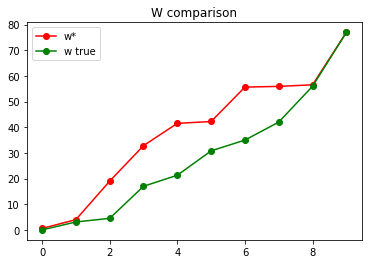

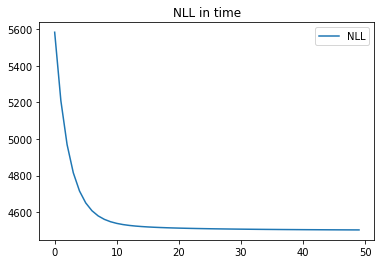

In [223]:
w = np.sort(X[np.random.choice(X.shape[0], size=10, replace=False)])

NLL_conv = []

for it in range(50):
  if it%5 == 0:
    print('Iteration ', it)
    print('........')
  w = grad_descent(X, w, 0.001)
  NLL_conv.append(NLL(X, w))

plt.plot(w, '-or', label='w*')
plt.plot(w_true, '-og', label='w true')
plt.title('W comparison')
plt.legend()
plt.show()
plt.plot(NLL_conv, label='NLL')
plt.title('NLL in time')
plt.legend()
plt.show()

### 4: The EM algorithm

The EM algorithm can be interpreted as a particular case of the MM algorithm. It can be applied to the estimation of the centers of a Gaussian mixture by expressing the NLL as a function of the random variable $z_k$, which indicates what component of the mixture has generated sample $x_k$. 

Note that $z_k$ is the variable that we used to generate the dataset, but it is not used to estimate ${\bf w}$.

Using the hidden variables, it can be shown that the NLL function can be upper bounded by
\begin{align}
u({\bf w}, \hat{\bf w}_n) 
   &= - \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}
                                         \{\log p({\bf z}, {\bf x}| {\bf w})\} 
      + \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}
                                         \{\log p({\bf z}| {\bf x}, \hat{\bf w}_n)\} \\
   &= - \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}\{\log p({\bf z}| {\bf x}, {\bf w})\} 
      + \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}
                                         \{\log p({\bf z}| {\bf x}, \hat{\bf w}_n)\}
      - \log p({\bf x}| {\bf w})  \\
   &= - \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}\{\log p({\bf z}| {\bf x}, {\bf w})\} 
      + \mathbb{E}_{{\bf z}| {\bf x}, \hat{\bf w}_n}
                                         \{\log p({\bf z}| {\bf x}, \hat{\bf w}_n)\}
      - \text{NLL}({\bf w})
\end{align}
Skipping the mathematical details, it can be show that this can be computed as
\begin{align}
u({\bf w}, \hat{\bf w}_n) 
%   &= - {\bf q}_n^\intercal\log({\bf q}) 
%      + {\bf q}_n^\intercal\log({\bf q}_n) 
%      - \log p({\bf x}| {\bf w})   \\
%   &=   {\bf q}_n^\intercal (\log(({\bf q}_n) - \log({\bf q})) 
%      - \log p({\bf x}| {\bf w}) \\
   &=   \mathbb{1}^\intercal({\bf Q}_n \odot (\log({\bf Q}_n) - \log({\bf Q})))\mathbb{1} 
      + \text{NLL}({\bf w})
\end{align}

#### 4.1 Upper bound.

Fix $w_1,w_2,\ldots,w_{M-1}$ to their true values, and consider the estimate $\hat{{\bf w}}$ given by $\hat{w}_1 = w_1$, ..., $\hat{w}_{M-1} = w_{M-1}$ and $\hat{w}_0 = 10$.

Represent both the NLL and its upper bound as a function of $w_0$.

(Note that,for the NLL part, you can re-use the code to solve sec. 2.2.)


In [0]:
def u(w_tr, w_star, data):

  eps = np.finfo(float).tiny

  p = gm(data, w_tr)
  p_star = gm(data, w_star)

  q = getQ(w_tr, data, p)
  qn = getQ(w_star, data, p_star)

  nll = NLL(data, w_tr)

  result = np.sum(qn*(np.log(qn+eps)-np.log(q+eps)), axis=(0,1)) + nll

  return result, nll

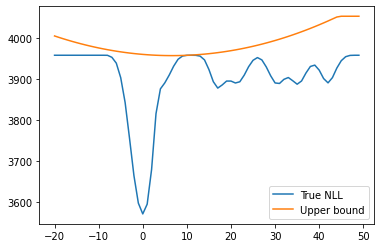

In [270]:
# <SOL>
w_em = np.array([[10., 3.1, 4.5, 17, 21.3, 30.8, 35., 42., 56., 77.]]).T

w0 = np.arange(-20,50)

NLL_convexity = []
UPB_convexity = []

for value in w0:
  
    w_true[0] = value

    up, nll = u(w_true, w_em, X)

    NLL_convexity.append(nll)
    UPB_convexity.append(up)
    
plt.plot(w0,NLL_convexity, label = 'True NLL')
plt.plot(w0,UPB_convexity, label = 'Upper bound')
plt.legend()
plt.show()

# </SOL>

#### 4.2. Testing EM

It can be shown that the EM algorithm for this problem leads to the iterative rule:
\begin{align}
{\bf w}_{n+1} = \frac{{\bf Q}_n{\bf x}}{{\bf Q}_n\mathbb{1}}
\end{align}
where the division should be computed component-wise.

Implement the learning rule, and plot the evolution of the NLL during time. Use the same initialization than the one used to apply GD.

Iteration  0
........
Iteration  5
........
Iteration  10
........
Iteration  15
........
Iteration  20
........
Iteration  25
........
Iteration  30
........
Iteration  35
........
Iteration  40
........
Iteration  45
........


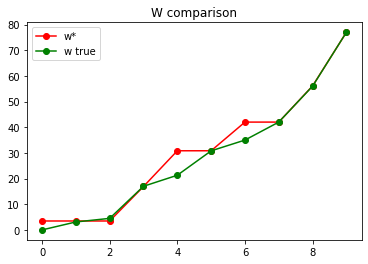

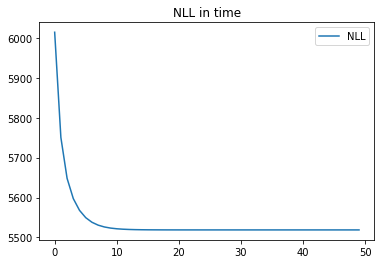

In [286]:
# <SOL>
w_em = np.sort(X[np.random.choice(X.shape[0], size=10, replace=False)])

NLL_em = []

for it in range(50):
  if it%5 == 0:
    print('Iteration ', it)
    print('........')
  p_em = gm(X, w_em)
  q_em = getQ(X, w_em, p_em)

  w_em =  q_em.T.dot(X) / np.sum(q_em.T, axis=1)
  NLL_em.append(NLL(X, w_em))

plt.plot(w_em, '-or', label='w*')
plt.plot(w_true, '-og', label='w true')
plt.title('W comparison')
plt.legend()
plt.show()
plt.plot(NLL_em, label='NLL')
plt.title('NLL in time')
plt.legend()
plt.show()
# </SOL>